# Proyecto 2
Andre Yahir Gonzalez Cuevas

Link: https://github.com/Andr3Glez/Proyecto_GANs

### Objetivos:
Comprender los principios fundamentales de las redes generativas antagónicas (GANs) y su aplicación en el aprendizaje profundo generativo.
Implementar una GAN básica y explorar variantes como las GANs condicionales o las CycleGANs para tareas específicas, como la generación de imágenes, traducción de imágenes o generación de texto.
Analizar el rendimiento y las características de los modelos generados por las GANs.

### Descripción:
Deberán seleccionar un conjunto de datos adecuado para su proyecto, que puede ser de imágenes, texto o cualquier otro tipo que permita la aplicación de GANs. Implementar una GAN, como una GAN básica, una GAN condicional o una CycleGAN, dependiendo de la naturaleza del conjunto de datos y el objetivo del proyecto. El proyecto incluirá una fase de experimentación donde los estudiantes deberán entrenar, ajustar y evaluar sus modelos. Presentar sus resultados a través de un informe escrito y una presentación, discutiendo la implementación, los desafíos encontrados, el rendimiento de sus modelos y las aplicaciones potenciales de su trabajo.

En este proyecto se usará una base de datos con imagenes de mujeres en la vida real y de anime, el objetivo es que se puedan pasar las imagens originales a formato o estilo anime y que mantenga la eacencia de la imagen original.

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets
En este código se define una clase llamada Dataset que será utilizada para cargar y transformar un conjunto de datos de imágenes para su uso en el entrenamiento y prueba en PyTorch.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        base_path = BASE_DATASET_PATH
        img_dir = os.path.join(base_path, img_dir)

        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)

        # Divide las rutas de imágenes en conjuntos de entrenamiento y prueba
        self.train_paths, self.test_paths = train_test_split([os.path.join(abspath, path) for path in path_list], test_size=0.2, random_state=42)

        self.transform = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), # Normalizar la imagen entre -1 y 1
        ])

    def __len__(self):
        return len(self.train_paths)

    def __getitem__(self, idx):
        path = self.train_paths[idx]
        img = Image.open(path).convert('RGB')

        img_tensor = self.transform(img)
        return img_tensor

# Discriminador
En la inicialización (__init__), se define la estructura del discriminador.
super(Discriminator, self).__init__() llama al constructor de la clase base nn.Module para inicializar el objeto Discriminator.

El parámetro conv_dim se utiliza para definir la dimensionalidad de los canales de características en las capas convolucionales.

Se definen una serie de capas convolucionales, cada una seguida de una función de activación LeakyReLU y, en la mayoría de las capas, una capa de normalización de instancia (nn.InstanceNorm2d). Estas capas convolucionales reducen progresivamente la dimensión espacial de las características mientras aumentan la profundidad de los canales.

La última capa convolucional produce una salida con un solo canal, que se utiliza para clasificar si la entrada es real o falsa.

El método forward define cómo se propaga la entrada a través del modelo.
Toma un tensor de entrada x que representa una imagen.
Este tensor se pasa a través de las capas definidas en self.main.

Luego de pasar por las capas convolucionales, se aplica una operación de promediado de la agrupación (F.avg_pool2d) sobre la salida para reducir las dimensiones espaciales a un solo valor por canal.

El tensor resultante se aplana (torch.flatten) para convertirlo en un tensor unidimensional.

Finalmente, este tensor se devuelve como salida del discriminador.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim=32):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, conv_dim, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim, conv_dim*2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*2, conv_dim*4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*4, conv_dim*8, 4, padding=1),
            nn.InstanceNorm2d(conv_dim*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*8, 1, 4, padding=1),
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

# ResidualBlock

El ResidualBlock ayuda a abordar el problema del desvanecimiento del gradiente y permite entrenar modelos más profundos de manera más efectiva.

El bloque residual consiste en dos convoluciones de 3x3 (ambas con un relleno de 1 píxel para mantener el tamaño) aplicadas a la entrada in_channels, seguidas de funciones de normalización de instancia (nn.InstanceNorm2d) y activaciones ReLU.

Esto permite que el bloque aprenda las diferencias entre la entrada y la salida, en lugar de aprender directamente la representación de la salida.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.main = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.main(x)

# Generador

El generador toma un tensor de ruido como entrada y produce una imagen generada como salida. La estructura del generador consiste en capas convolucionales, bloques residuales y capas de convolución transpuesta para transformar el ruido de entrada en una imagen generada de alta calidad.

El generador comienza con una capa de reflexión (nn.ReflectionPad2d) seguida de una convolución de 7x7 que aumenta la dimensionalidad de las características de entrada a conv_dim. Después de esto, se aplica una normalización de instancia y una activación ReLU.

Se siguen dos capas convolucionales, que reducen las dimensiones espaciales de las características mientras aumentan su profundidad.

Se agregan 9 bloques residuales (ResidualBlock) para aprender las características residuales de la imagen.

Termina con una capa de reflexión, una convolución de 7x7 y una función de activación Tanh, que escala los valores a un rango de [-1, 1]

In [ ]:
class Generator(nn.Module):
    def __init__(self, conv_dim=64, n_res_block=9):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, conv_dim, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(conv_dim, conv_dim*2, 3, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv_dim*2, conv_dim*4, 3, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*4),
            nn.ReLU(inplace=True),

            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),

            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(conv_dim*2, conv_dim, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(conv_dim, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# CycleGAN
Esta clase implementa el ciclo de entrenamiento completo para el modelo CycleGAN, incluyendo la definición de arquitecturas de red, el cálculo de las pérdidas y el ciclo de entrenamiento.

Para las funciones de perdida se usaran varias para poder tener una mejor idea de la perdida, esto se hizo basado en el AnimeGans.

real_mse_loss calcula la pérdida cuadrática media entre las salidas del discriminador y el valor de referencia "real" (1 para imágenes reales).

fake_mse_loss calcula la pérdida cuadrática media entre las salidas del discriminador y el valor de referencia "falso" (0 para imágenes falsas).

cycle_consistency_loss calcula la pérdida de consistencia cíclica entre la imagen original y la imagen reconstruida.

In [ ]:
class CycleGAN:

    def __init__(self, g_conv_dim=64, d_conv_dim=64, n_res_block=6):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

        self.G_XtoY = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)
        self.G_YtoX = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)

        self.D_X = Discriminator(conv_dim=d_conv_dim).to(self.device)
        self.D_Y = Discriminator(conv_dim=d_conv_dim).to(self.device)

        print(f"Models running of {self.device}")

    def load_model(self, filename):
        save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
        return torch.load(save_filename)

    def real_mse_loss(self, D_out):
        return torch.mean((D_out-1)**2)


    def fake_mse_loss(self, D_out):
        return torch.mean(D_out**2)


    def cycle_consistency_loss(self, real_img, reconstructed_img, lambda_weight):
        reconstr_loss = torch.mean(torch.abs(real_img - reconstructed_img))
        return lambda_weight*reconstr_loss


    def train_generator(self, optimizers, images_x, images_y):
        # Generator YtoX
        optimizers["g_optim"].zero_grad()

        fake_images_x = self.G_YtoX(images_y)

        d_real_x = self.D_X(fake_images_x)
        g_YtoX_loss = self.real_mse_loss(d_real_x)

        recon_y = self.G_XtoY(fake_images_x)
        recon_y_loss = self.cycle_consistency_loss(images_y, recon_y, lambda_weight=10)


        # Generator XtoY
        fake_images_y = self.G_XtoY(images_x)

        d_real_y = self.D_Y(fake_images_y)
        g_XtoY_loss = self.real_mse_loss(d_real_y)

        recon_x = self.G_YtoX(fake_images_y)
        recon_x_loss = self.cycle_consistency_loss(images_x, recon_x, lambda_weight=10)

        g_total_loss = g_YtoX_loss + g_XtoY_loss + recon_y_loss + recon_x_loss
        g_total_loss.backward()
        optimizers["g_optim"].step()

        return g_total_loss.item()


    def train_discriminator(self, optimizers, images_x, images_y):
        # Discriminator x
        optimizers["d_x_optim"].zero_grad()

        d_real_x = self.D_X(images_x)
        d_real_loss_x = self.real_mse_loss(d_real_x)

        fake_images_x = self.G_YtoX(images_y)

        d_fake_x = self.D_X(fake_images_x)
        d_fake_loss_x = self.fake_mse_loss(d_fake_x)

        d_x_loss = d_real_loss_x + d_fake_loss_x
        d_x_loss.backward()
        optimizers["d_x_optim"].step()


        # Discriminator y
        optimizers["d_y_optim"].zero_grad()

        d_real_y = self.D_Y(images_y)
        d_real_loss_x = self.real_mse_loss(d_real_y)

        fake_images_y = self.G_XtoY(images_x)

        d_fake_y = self.D_Y(fake_images_y)
        d_fake_loss_y = self.fake_mse_loss(d_fake_y)

        d_y_loss = d_real_loss_x + d_fake_loss_y
        d_y_loss.backward()
        optimizers["d_y_optim"].step()

        return d_x_loss.item(), d_y_loss.item()


    def train(self, optimizers, data_loader_x, data_loader_y, print_every=10, sample_every=100):
        losses = []
        g_total_loss_min = np.Inf

        fixed_x = next(iter(data_loader_x))[1].to(self.device)
        fixed_y = next(iter(data_loader_y))[1].to(self.device)

        print(f'Running on {self.device}')
        for epoch in range(EPOCHS):
            for (images_x, images_y) in zip(data_loader_x, data_loader_y):
                images_x, images_y = images_x.to(self.device), images_y.to(self.device)

                g_total_loss = self.train_generator(optimizers, images_x, images_y)
                d_x_loss, d_y_loss = self.train_discriminator(optimizers, images_x, images_y)


            if epoch % print_every == 0:
                losses.append((d_x_loss, d_y_loss, g_total_loss))
                print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'
                .format(
                    epoch,
                    EPOCHS,
                    d_x_loss,
                    d_y_loss,
                    g_total_loss
                ))

            if g_total_loss < g_total_loss_min:
                g_total_loss_min = g_total_loss

                torch.save(self.G_XtoY.state_dict(), "G_X2Y")
                torch.save(self.G_YtoX.state_dict(), "G_Y2X")

                torch.save(self.D_X.state_dict(), "D_X")
                torch.save(self.D_Y.state_dict(), "D_Y")

                print("Models Saved")



        return losses

# Configuracion de las clases

N_WORKERS: Es el número de subprocesos que se utilizarán para cargar los datos. Aquí se ha establecido en 0, lo que significa que no se usarán subprocesos adicionales.

IMG_SIZE: Es el tamaño al que se redimensionarán las imágenes. Aquí se ha establecido en 64x64 píxeles.

LR (tasa de aprendizaje), BETA1 y BETA2: Son los parámetros de optimización utilizados en el optimizador Adam para el entrenamiento de la red. La tasa de aprendizaje (LR) se ha establecido en 0.0002, y BETA1 y BETA2 son los parámetros de decaimiento de momento y la tasa de decaimiento de momento cuadrático respectivamente, ambos establecidos en 0.5 y 0.999.

In [ ]:
BASE_DATASET_PATH = "/content/drive/MyDrive/Deep_Learning/Proyecto_2"
X_DATASET = "selected_faces"
Y_DATASET = "selected_anime"

BATCH_SIZE = 32
N_WORKERS = 0

IMG_SIZE = 64
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999

EPOCHS = 50

Train

In [ ]:
# Train
x_train_dataset = Dataset(X_DATASET)
y_train_dataset = Dataset(Y_DATASET)

data_loader_x_train = DataLoader(x_train_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y_train = DataLoader(y_train_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

In [ ]:
# Model
cycleGan = CycleGAN()

# Oprimizer
g_params = list(cycleGan.G_XtoY.parameters()) + list(cycleGan.G_YtoX.parameters())

optimizers = {
    "g_optim": optim.Adam(g_params, LR, [BETA1, BETA2]),
    "d_x_optim": optim.Adam(cycleGan.D_X.parameters(), LR, [BETA1, BETA2]),
    "d_y_optim": optim.Adam(cycleGan.D_Y.parameters(), LR, [BETA1, BETA2])
}

# Train
losses = cycleGan.train(optimizers, data_loader_x_train, data_loader_y_train, print_every=1)

Models running of cuda
Running on cuda
Epoch [    0/   50] | d_X_loss: 0.4953 | d_Y_loss: 0.4028 | g_total_loss: 7.7897
Models Saved
Epoch [    1/   50] | d_X_loss: 0.3744 | d_Y_loss: 0.3370 | g_total_loss: 5.7881
Models Saved
Epoch [    2/   50] | d_X_loss: 0.3296 | d_Y_loss: 0.3561 | g_total_loss: 6.1942
Epoch [    3/   50] | d_X_loss: 0.5455 | d_Y_loss: 0.2882 | g_total_loss: 6.2037
Epoch [    4/   50] | d_X_loss: 0.3995 | d_Y_loss: 0.4517 | g_total_loss: 6.0089
Epoch [    5/   50] | d_X_loss: 0.3799 | d_Y_loss: 0.4995 | g_total_loss: 5.5826
Models Saved
Epoch [    6/   50] | d_X_loss: 0.2875 | d_Y_loss: 0.5457 | g_total_loss: 7.5640
Epoch [    7/   50] | d_X_loss: 0.3513 | d_Y_loss: 0.3914 | g_total_loss: 6.3097
Epoch [    8/   50] | d_X_loss: 0.3675 | d_Y_loss: 0.2400 | g_total_loss: 6.4039
Epoch [    9/   50] | d_X_loss: 0.3779 | d_Y_loss: 0.3740 | g_total_loss: 5.0727
Models Saved
Epoch [   10/   50] | d_X_loss: 0.3935 | d_Y_loss: 0.2675 | g_total_loss: 5.8366
Epoch [   11/   50

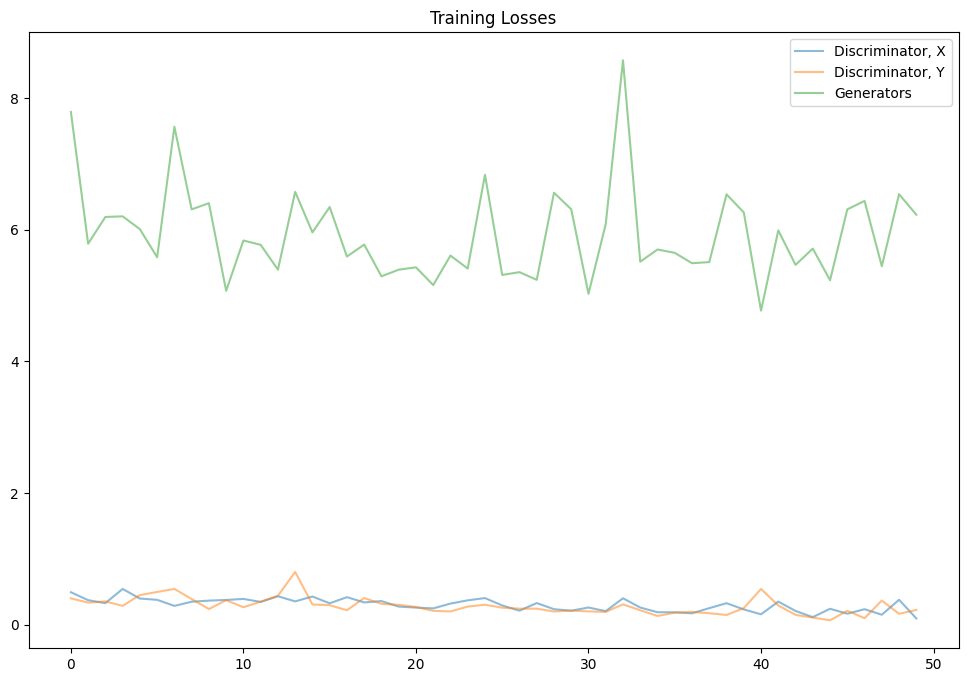

In [ ]:
# Visualizacion del comportamiento del Discriminador
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

In [ ]:
# Test
x_test_dataset = Dataset(X_DATASET)
y_test_dataset = Dataset(Y_DATASET)

data_loader_x_test = DataLoader(x_test_dataset, BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)
data_loader_y_test = DataLoader(y_test_dataset, BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)
samples = []

for i in range(12):
    fixed_x = next(iter(data_loader_x_test))[i].to(cycleGan.device)
    fake_y = cycleGan.G_XtoY(torch.unsqueeze(fixed_x, dim=0))
    samples.extend([fixed_x, torch.squeeze(fake_y, 0)])

Resultados

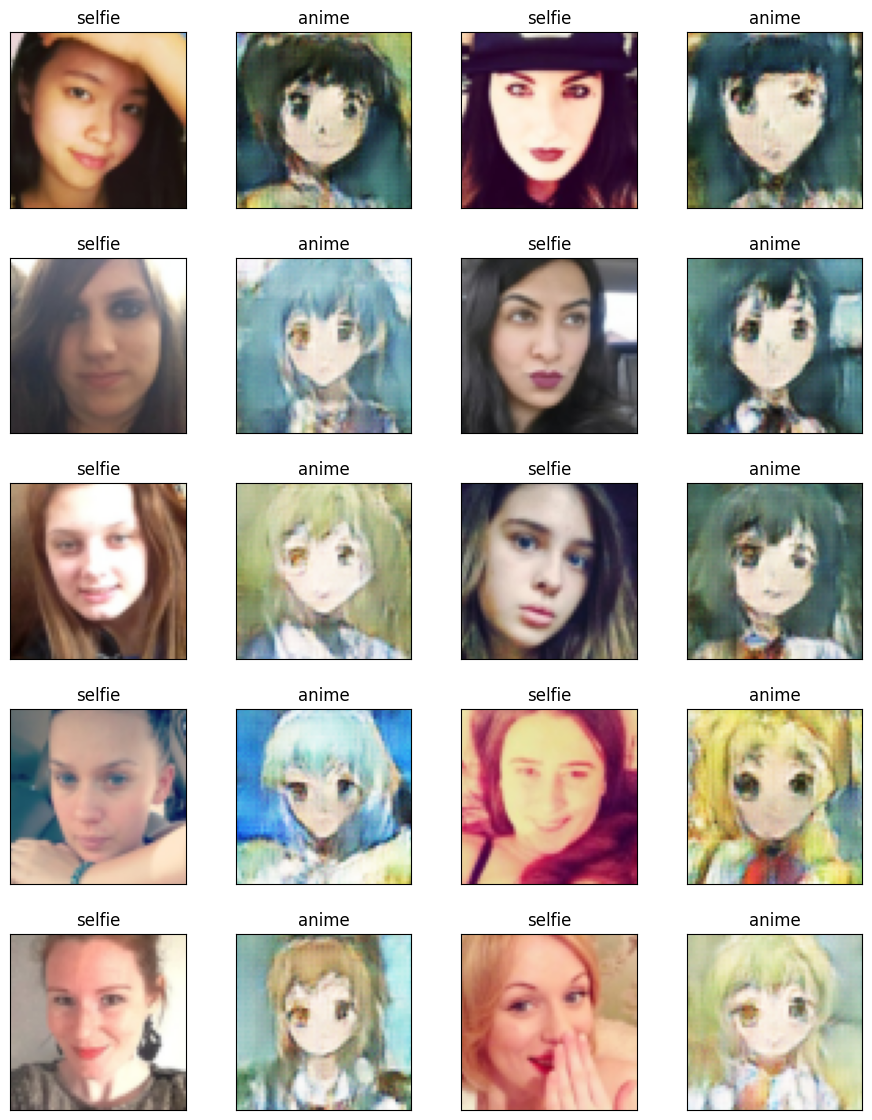

In [ ]:
fig = plt.figure(figsize=(18, 14))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 4), axes_pad=0.5)


for i, (ax, im) in enumerate(zip(grid, samples)):
    _, w, h = im.size()
    im = im.detach().cpu().numpy()
    im = np.transpose(im, (1, 2, 0))

    im = ((im +1)*255 / (2)).astype(np.uint8)
    ax.imshow(im.reshape((w,h,3)))

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if i%2 == 0: title = "original"
    else: title = "anime"

    ax.set_title(title)

plt.show()

Podemos ver que el resultado fue bueno el problema está en los ojos, fue donde más se confundía.

Ayudo mucho la investigacion de como funcionaba AnimeGAN, ya que de ahí pude buscar como mejorar el discriminador y pude encontrar la base de datos para tener las caras en anime, ya que al inicio intente usar una herramienta de google Download All, la cual descarga todas las fotos de google imagenes pero tuve que eliminar una por una las que no eran, por lo que fue mejor usar la base de datos probada, al igual que solo usar caras de mujeres.

Me sirvio mucho ver como funcionaba las medidas de perdida en Anime GAN para entender que es mejor hacer combinaciones de metricas de perdida y no solo una.

Me gustaría pobrar el siguiente proyecto algo diferente ya que en la investigacion, vi que había ya muchos trabajos como este pero fue lo que me ayudo a poder obtener resultados buenos.